# Część pierwsza
<div class="alert alert-block alert-danger">
<b>Uwaga:</b> Należy upewnić się że w prawym górnym rogu tego okna wybrany jest kernel "edugen" a nie "Python 3"
</div>

***
## Format FASTQ

Pliki FASTQ są plikami źródłowymi, na podstawie których wynokuje się kolejne kroki w toku przetwarzania danych NGS. Są one generowane na podstawie obrazów rejestrowanych przez sekwenator. 

<img src="png/1_pipeline.png">
FASTQ jest formatem przechowującym informację o sekwencji odczytów oraz ich jakości. Każdy odczyt składa się z 4 linii tekstu.

<br>

| Linia | Opis |
|:------|:-----|
|   1   | Zaczyna się od znaku "@", po nim znajdują się informację o maszynie, flowcell, koordynatach do danego klastra itp. |
|   2   | Sekwencja DNA |
|   3   | Zaczyna się od znaku "+", oddziela sekwencję od informacji o jakości, może zawierać takie same dane jak w linii 1 |
|   4   | Ciąg znaków reprezentujący jakość odczytu dla danego nukleotydu, musi mieć taką samą długość jak w linii 2 |

<br>

W początkowym notatniku przy okazji ściągania plików oraz tworzenia folderów roboczych dokonaliśmy konwersji plików BAM, zawierających uliniowione odczyty, do plików FASTQ. Konwersja tych plików jest możliwa dzięki ich strukturze, o której dowiemy się wiecej na dzisiejszych zajęciach.


Możemy podejrzeć pierwsze dwa sparowane odczyty z pliku `mother.fq` znajdującego się w folderze `fastq/` przy użyciu komendy bash `!head`. Dla tej komendy argument `-n 8` określa liczbę linii tesktu które chcemy wyświetlić (domyślnie jest to 10).

In [ ]:
! head -n 8 fastq/mother.fq

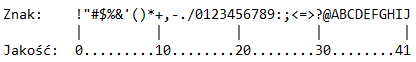Wyświetlone odczyty mają standardową formę opisana w tabelce powyżej. Po informacji w nagłówku, w kolejnej linijce wyświetlana jest sekwencja odczytu, a w ostatniej ciąg znaków określający jakość odczytu.
***
## Jakość odczytu nukleotydu
***
Ostatnia linia przedstawia jakość odczytu dla każdego nukleotydu w danym odczycie. Jakość jest określana jako prawdopodobieństwo odczytu nieprawidłowego nukleotydu. Jest to standardowy sposób kodowania znany pod nazwą PHRED i jest szeroko używany do oceny jakości odczytów otrzymywanych przy sekwencjonownaiu DNA.<br>
<br>Wynik PHRED = **10** oznacza że prawdopodbieństwo błednego odczytu nukleotydu wynosi 1 do 10 (trafność **90%**)
<br>Wynik PHRED = **20** oznacza że prawdopodbieństwo błednego odczytu nukleotydu wynosi 1 do 100 (trafność **99%**)
<br>Wynik PHRED = **30** oznacza że prawdopodbieństwo błednego odczytu nukleotydu wynosi 1 do 1000 (trafność **99,9%**) itd.

Jakość w postaci liczby (wynik PHRED) jest przypisana do kokretnego znaku. Format kodowania tych wartości zależy od platformy na której przeprowadzane jest sekwencjonowanie, jednak większość opiera się na standardowym formacie używanym przy sekwencjonowaniu Sangera, gdzie jakość może przybierać wartość od 0 do 93. Dla sekwencjonowania Sangera jakość odczytu rzadko przekracza 60, natomiast dla aktualnej chemii używanej przy sekwencjonoaniu na platformie Illumina maksymalna wartość to zazwyczaj 41. Poniżej przedstawiono znaki używane do kodowania jakości oraz odpowiadające im wartości.

<img src="png/phread.png">

<div class="alert alert-block alert-warning">
<b>Zadanie 1:</b> Na podstawie powyższych informacji co można powiedzieć o jakości odczytu który oglądaliśmy wcześniej?
</div>
<div class="alert alert-block alert-warning">
<b>Zadanie 2:</b> Na podstawie powyższych informacji co można powiedzieć o jakości dwóch pierwszych odczytów w próbce <b>son.fq</b>? Użyj odpowiedniej komendy aby wyświetlić te odczyty.
</div>

***
## Oszacowanie jakości z użyciem modułu pandas i pysam
***
Struktura plików FASTQ pozawala nam na konwersje tych plików do formy tabelki i ręczną analizę otrzymanych danych. Moduł `pysam` oferuje [liczne komendy](https://pysam.readthedocs.io/en/latest/api.html) pozwalające na operacje na plikach zawierających dane o sekwencjach nukleotydowych, w tym także plikach FASTQ. Operacje na tych plikach wykonuje się z użyciem komendy `pysam.FastxFile`. Daje ona możliwość iteracji wszystkich odczytów w pliku i dostep do informacji w tych odczytach. Poszczególne linie dla plików FASTQ są opisane jako kolejno: `name`, `sequence`, `comment` oraz `quality`. Łacząc funkcjonalność tego modułu z modułem `pandas`, który umożliwia szybką i łatwą analizę danych, możemy wyeksportować dane z pliku FASTQ do DataFrame'u (rodzaj tabeli obsługiwany przez moduł `pandas`)

In [ ]:
import pysam
from pandas import DataFrame
fastqfile = "fastq/mother.fq"
with pysam.FastxFile(fastqfile) as fh:
    df = DataFrame([[r.name, r.sequence, r.quality]\
                    for r in fh])
    print(df)

Otrzymaliśmy DataFrame zawierający 3 kolumny i 133160 wierszy. Na tej podstawie jesteśmy w stanie określić, że plik `mother.fq` zawiera 133160 odczytów. Przygladając sie pierwszej kolumnie, zauważmy że nazwy odczytów kończą się **/1** lub **/2**. Oznacza to, że plik ten zawiera sparowane odczyty w jednym pliku FASTQ. Często sparowane odczyty przechowywane są osobno w dwóch oddzielnych plikach, niekiedy również występuje 3 plik FASTQ. Zazwyczaj zawiera on pozostałe odczyty które nie zostały sparowane.
***
Moduł `pysam` umożliwia również konwersję jakości odczytów z formatu ASCII na bardziej przystępną formę liczbową. Służy do tego komenda `pysam.qualitystring_to_array()`, która przyjmuje jako argument ciąg znaków jakości, który zwraca następnie w postaci szeregu wartości. Przykład funkcjonalności tej komendy poniżej:

In [ ]:
qual = pysam.qualitystring_to_array('!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJ')
print(qual)

Jak widzimy podany przy okazji definicji wyniku PHRED ciąg znaków ASCII został zwrócony jako kolejne liczby określające jakość odczytu. W tym przypadku trzeba było zastosować znak modyfikacji `\` przed znakiem `'` tak aby komenda nie traktowała go jako końca argumentu.

<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Na podstawie powyższych przykładów stwórz DataFrame z użyciem modułów pysam i pandas, zawierający wyłacznie informację o jakości odczytów w postaci liczbowej dla pliku <b>mother.fq</b>. DataFrame zachowaj pod nazwą zmiennej <b>df</b>.
</div>

***
Posiadając liczbowe dane dotyczące odczytów możemy przeprowadzić liczne analizy, np. obliczyć średnią jakość dla wszytskich odczytów w próbce, czy dla poszczególnych odczytów. W poniższym przykładzie obliczymy średnią (komenda `.mean` dla której argument `axis=1` oznacza wykonanie operacji na wierszach, natomiast `axis=0` na kolumnach) dla pierwszych dwudziestu odczytów w naszym DataFrame (komenda `.iloc[zakres wierszy, zakres kolumn]`). Na początku musimy nadać nazwę kolumnie (komenda `.columns=[]`) a następnie przekonwertować DataFrame na wartości liczbowe przechowywane w liście (komenda `.values.tolist()`).

In [ ]:
df.columns = ["quals"]
df2 = DataFrame(df.quals.values.tolist())
df2.iloc[0:20,:].mean(axis=1)

Większość odczytów spośród 20 pierwszych w tym pliku ma zadowalającą średnią jakość odczytów, oscylującą w granicach 20-30. Przyjrzyjmy się bliżej 4 odczytowi, którego średnia jakość wynosi 14. Możemy podejrzeć ten odczyt używając komendy bash `sed`, która wyświetla wycinek tekstu.

In [ ]:
! sed -n '13,16p' fastq/mother.fq
print(df2.iloc[3,:])

***
Odczyt ten jest bardzo niskiej jakości, od około połowy odczytu wynik PHRED dla odczytywanych nukleotydów ma znak # który odpowiada wartości 2. Oznacza to że w tych pozycjach prawdopodobieństwo złego odczytu nukleotydu przez sekwenator jest bardzo duże.

<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Na podstawie powyższych przykładów wyznacz średnią jakość dla nukleotydów w pozycjach od 1 do 10 dla wszystkich odczytów w pliku mother.fq. Następnie w kolejnej komórce zrób to samo dla ostatnich 10 odczytów (od 141 do 151). Jakie wnioski możemy wyciągnąć na podstawie tych dwóch wyników?
</div>

***
## Oszacowanie jakości z użyciem programu FastQC
***
W praktyce jakości sekwencjonowania nie ocenia się przeglądając pliki FASTQ ręcznie. W tym celu wykorzystuje sie oprogramowanie pozwalające na zbiorczą ocenę jakości odczytów dla danej próbki. Jednym z takich programów jest FastQC, który analizuje jakość odczytów i przedtawia je w postaci wykresu. Program ten rozpatruje jakość dla wszystkich odczytów w ramach konretnej próbki, zamiast dla pojedynczego odczytu. Graficzna reprezentacja wyniku w postaci wykresu pozwala na określenie czy otrzymane dane są odpowiednie dla dalszej analizy.

### Używanie programu FastQC
Program FastQC jest zainstalowany w systemie, dlatego wywołujemy go komendą bash `! fastqc`. Program ten odczytuje pliki FASTQ i dla każdego z nich tworzy raport złożony z kilku modółow o których opowiemy potem. Po komendzie `fastqc` określamy pliki które mają zostac przeanalizowane. Za pomocą argumentu -o możemy okreslić miejsce gdzie ma zostać zapisany wygenerowany raport (domyślnie zostanie zapisany w folderze gdzie znajdują sie pliki FASTQ). Program pozwala różwnież na analizę wielu plików naraz (zarówno w formie skompresowanej jak i zwykłej), które możemy określić po konkretnej nazwie próbki, lub używając symbolu wieloznacznego - `*.fq`. Dokumentację dla programu można wyświetlić za pomocą komendy `!fastqc -help` lub pod [tym linkiem](https://manpages.debian.org/stretch/fastqc/fastqc.1.en.html)
<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Na podstawie powyższych informacji przeprowadź analizę z użyciem programu FastQC dla wszystkich plików .fastq które skopiwaliśmy do swoich folderów roboczych (fastq). Raporty zapiszemy w folderze <b>sandbox/fastqc_reports</b>.
</div>

In [ ]:
! fastqc fastq/*.fq -o sandbox/fastqc_reports/

***
Plikami wynikowymi działania programu są pliki `.zip` i `.html`. Dla nas najbardziej interesujący jest plik `.html` zawierający raport dla danej próbki. Możemy go podejrzeć w tym notatniku wykorzystując funkcję modułu IPython o nazwię `IFrame` która pozwala na wyświetlanie plików `.html` wewnątrz komórek notatnika.

In [ ]:
from IPython.display import IFrame
IFrame('png/mother_fastqc.html', width='100%', height=700)

# Omówienie poszczególnych modułów FastQC

## Per base sequencing quality
Moduł ten przedstawia w formie wykresu pudełkowego jakość dla nukleotydów na poszczególnych pozycjach dla wszystkich odczytów w danym pliku. Żółte pudełka określają przedział międzykwartylowy (25%-75%), wąsy wykresu zakres od 10%-90%, czerwone linie reprezentują medianę, a niebieska linia średnią jakość. Tło dzieli wykres kolorami na 3 obszary - zielony oznacza bardzo dobrą jakość odczytu, żółte umiarkowanie dobrą jakość, a czerwony słabą jakość. Przykład wykresów przedstawiających dobre i słabe wyniki przedstawiono poniżej. Dla sekwenatorów Illuminy często można zaobserwować niższą jakośc pierwszych kilku odczytów. Dosyć często również obserwowane jest zjawisko spadku jakości odczytów wraz z czasem trwania reakcji. Jest to spowodowane zjawiskami takimi jak phasing (utrata synchronizacji kolejnych cykli sekwencjonowania w obrębie jednego klastra) czy osłabienia sygnału fluorescencyjnego.

<img src="png/3_per_base_seq_qual.png" width="1000">

## Per tile sequence quality
Wykres ten pojawia się wyłacznie dla bibliotek Illuminy, gdzie zachowane zostały oryginalne nazwy odczytów. Zakodowane sa w nich koordynaty dla konkretnych klastrów znajdujących się na flowcelli, co pozwala na wizualizację w któym obszarze dochodziło do spadku jakości odczytów. Idealnie wykres powinine być niebieski na całej powierzchni, cieplejsze kolory oznaczają rejony o gorszej jakości odczytów.

## Per base quality score
Wykres przedstawiający całkowita liczbę odczytów względem średniej jakości dla całego odczytu. Przykład wykresów przedstawiających dobre i słabe wyniki przedstawiono poniżej. Pik wykresu na wyoskości powyżej wartości 28 dla jakości swiadczy o dobrej jakości odczytów.

<img src="png/4_per_base_qual_score.png" width="1000">

## Per base sequence content
Wykres ten przedstawia procentową ilość wszystkich czterech nukleotydów na długości wszystkich odczytów w danej próbie. W założeniu ich stosunek powinien być w miarę podobny, przy czym %A=%T oraz %C=%G. Duże różnice mogą być spowodowane kontaminacją przygotowanej biblioteki. Również niektóre typy bibliotek , takie jak RNA-seq czy ChIP-seq moga mieć nieprawidłowy procentowy udział nukleotydów. Poniżej przykład nieprawidłowych wykresów - pierwszy wskazujący na kontaminację, drugi w którym nie usunięto sekwencji adapterów na początku odczytów.

<img src="png/5_per_base_seq_cont.png" width="1000">

## Per sequence GC content
Wyświetla wykres procentowej ilości GC w odczytach względem wszystkich odczytów. W losowej bibliotece rozkład ten powinien być zbliżony do rozkładu normalnego, gdzie główny pik odpowiada średniej ilości GC w danym genomie. Wykres odbiegający od rozkładu normalnego może swiadczyć o kontaminacji biblioteki, natomiast przesuniecię wykresu względem teoretycznie wyznaczonego rozkładu, lub ostre piki moga sugerować obecność nadreprezentowanych sekwencji. Poniżej przykład nieprawidłowego wykresu.

<img src="png/6_per_seq_GC.png" width="1000">

## Per base N content
Wykres przedstawia procentowy udział nukleotydów które nie zostały odczytane, oznaczanych jako `N` w sekwencji. Zazwyczaj pojawiają się pod koniec odczytów, wraz ze spadkiem jakości odczytów, jednak ich ilość nie powinna przekraczać 20%.


## Sequence length distribution
Wykres przedstawiający ilość sekwencji o konkretnej długości. Niektóre sekwenatory generują odczyty o jednakowej długości, w przypadku innych długość odczytów może być zmienna. Niektóre odczyty moga być również przycinane w celu usunięcia sekwencji o niskiej jakości. Poniżej przykład wykresu z odczytami o bardzo zróżnicowanej długości.

<img src="png/7_seq_len_dist.png" width="1000">

## Sequence duplication levels
Wykres przedstawia procentową ilość zduplikowanych sekwencji. W idealnym przypadku każda sekwencja będzie wstępowała tylko raz. Obecność dużej ilości zduplikowanych odczytów pozwala zidentyfikować bibliotekę o niskiej złożoności, co może być spowodowane zbyt małą ilością materiału DNA, lub zbyt dużą ilością cykli amplifikacji w trakcie reakcji PCR.


## Overrepresented sequences
Tabelka w któej znajdują się sekwencje o długości conajmniej 20 pz. które występują w conajmniej 0.1% wszystkich sekwencji. Pozwala to pomóc w rozpoznaniu ewentualnego źródła kontaminacji biblioteki.


## Adapter content
Wykres przedstawiający procentowy udział sekwencji w których rozpoznano obecnośc sekwencji należacych do adaptera. Idealnie sekwencje nie powinny zawierać sekwencji adapterowych, jednak mogą się one pojawić w przypadku sekwencjonowania z użyciem długich odczytów, gdzie niektóre z insertów mogą być krótsze niż długość odczytu. Powoduje to zmapowanie sekwencji adaptera znajdującego się na końcu 3'.

## Kmer content
Wykres ten przedstawia pomiar zawartości wszystkich którtkich sekwencji nukleotydowych o długości k (domyślnie 7 nt.) we wszystkich odczytach. Każdy "Kmer" powinien być jednakowo reprezentowany na przestrzeni całej sekwencji. Lista 6 najczęstszych Kmer-ów które występują na specyficznych pozycjach z większą częstością niż oczekiwana jest pokazywana na wykresie. Moduł ten bywa trudny do interpretacji, więcej informacji pod [linkiem](http://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/11%20Kmer%20Content.html).


***
# MultiQC
Program MultiQC umożliwia generowanie raportów zbiorczych dla wielu plików na podstawie raportów z niemal 80 innych programów, takich jak FastQC czy GATK. Więcej informacji o programie oraz lista obsługiwanych raportów pod [tym linkiem](https://multiqc.info/). Jest to bardzo wygodne narzędzie do zbiorczej analizy wielu próbek naraz. Program wywołujemy komendą bash `! multiqc`, podając ścieżkę do folderu zawierającego raporty, oraz ścieżke do folderu gdzie chcemy wygenerować raport zbiorczy, którą podajemy po argumencie `-o`. Plik wynikowy, podobnie jak w przypadku FastQC, ma format `.html`.
<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Na podstawie powyższych informacji przeprowadź analizę z użyciem programu MultiQC dla wszystkich trzech raportów wygenerowanych wcześniej. Plik wynikowy zapisz w tym samym folderze co raporty FastQC.
</div>

In [ ]:
! multiqc -o sandbox/fastqc_reports/ sandbox/fastqc_reports/

In [ ]:
from IPython.display import IFrame
IFrame('png/multiqc_report.html', width='100%', height=700)

## Trimming
W procesie sekwencjonowania nastepnej generacji z użyciem platformy Illumina do pociętych sekwencji badanego DNA przyłaczane sa adaptery, umożliwiające przeprowadzenie reakcji sekwencjonowania jak również ustalenie do której próbki należy dany odczyt, gdy sekwencjonujemy kilka próbek w jednej reakcji. Przykłądy różnych adapterów przedstawiono poniżej na grafice:

<img src="png/8_adaptor.png" width="800">

Adaptery te również są sekwencjonowane i należy je usunąć. Programy przycinąjące sekwencje adapterów zazwyczaj usuwają również fragmenty odczytów o niskiej jakości w celu zmniejszenia szansy uzyskania fałszywie pozytywnych wyników. Istnieje wiele programów oferujących podobną funkcjonalność. W naszym przypadku pliki FASTQ zostały już pozbawione adapterów, dlatego nie będziemy wykonywać tego kroku.

***
# Przyrównywanie do sekwencji referencyjnej (uliniowienie)
Przyrównanie do sekwencji referencyjnej wykonuje się w celu ustalenia gdzie w obrębie sekwencji referencyjnej lokalizują się dane odczyty. Najpopularniejsze programy służące do tego celu to **BWA** i **bowtie2**, na zajęciach skorzystamy z tego pierwszego.
<br>
<br>
Proces uliniowienia składa się z dwóch etapów:
1. Indeksowania sekwencji (genomu) referencyjnego
1. Przyrównania odczytów do sekwencji referencyjnej (uliniowienia)

## Indeksowanie sekwencji referencyjnej
Indeksowanie ma za zadanie ułatwienie programowi znalezienie potencjalnych miejsc gdzie dany odczyt może zostać przyrównany. Indeksowanie wykonuje się tylko raz dla danej sekwencji referencyjnej. W programie BWA dokonujemy tego za pomocą komendy `index` określając lokalizację pliku z sekwencją referencyjną w formacie FASTA. W naszym przypadku wycinek referencyjnego genomu człowieka w wersji 19 (GRCh_37 - hg19) został już zindeksowany, ze względu na długi czas trwania tego procesu dla dużych genomów. Znajduje się on w folderze `ref/ref.fasta`.

***
## Uliniowienie
Przyrównanie do referencji wymaga sprecyzowania sekwencji referencyjnej oraz algorytmu który ma tego dokonać. Najczęściej stosowanym i rekomendowanym algorytmem jest BWA-MEM który wykorzystuje transformację Burrows-Wheeler'a. Dokonuje się tego za pomocą komendy `mem`, określając lokazlicaję sekwencji referencyjnej, pliku fastq (bądź dwóch plików w przypadku odczytów sparowanych) oraz podając lokalizację i nazwę pliku SAM który ma zostac utworzony. O plikach w formacie SAM/BAM opowiemy za chwilę.

Komenda `mem` posiada wiele parametrów które możemy zmieniać, co może mieć istotny wpływ na cały proces uliniowienia. Na zajęciach użyjemy argumentu `-p` który informuje program że nasz plik zawiera sparowane odczyty, natomiast wiecej informacji o dostępnych opcjach znajduje się w dokumentacji programu [BWA](http://bio-bwa.sourceforge.net/bwa.shtml).
<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Na podstawie powyższych informacji oraz dokumentacji programu przeprowadź uliniowienie pliku <b>mother.fq</b>. Wyjściowy plik SAM zapisz w folderze <b>sandbox</b>. Ścieżka do sekwencji referencyjnej genomu - <b>ref/ref.fasta</b>
</div>

***
## Format SAM
Plik wynikowy uliniowienia ma rozszerzenie `.sam` i jest plikiem tekstowym podzielonym tabulatorami. Zawiera informację na temat poszczególnych odczytów oraz ich przyrównaniu do sekwencji referencyjnej. Plik ten może zawierać nagłówek z informacją o sekwencji referencyjnej, metodzie uliniowienia itp. Nagłówek możemy podejrzeć za pomocą funkcji `view` programu `samtools`, dodając argument `-H` oraz ścieżke do pliku.

In [ ]:
! samtools view -H sandbox/mother.sam

 ***
 W kolejnej sekcji znajdują się informację o przyrównanych odczytach. Każda linia opisuje pojedynczy odczyt i posiada 11 wymaganych pól z informacjami. Przykład:
<img src="png/9_SAM.png" width="800">
<br>

| Pozycja | Pole  | Opis                                                         |
|---------|-------|--------------------------------------------------------------|
| 1       | QNAME | Nazwa odczytu                                                |
| 2       | FLAG  | Wartość FLAG                                                 |
| 3       | RNAME | Nazwa sekwencji referencyjnej                                |
| 4       | POS   | Pozycja na sekwencji referencyjnej dla pierwszego nukleotydu |
| 5       | MAPQ  | Jakość mapowania (w skali PHRED)                             |
| 6       | CIAGR | Ciąg znaków CIGAR                                            |
| 7       | MRNM  | Nazwa sekwencji referencyjnej dla następnego odczytu         |
| 8       | MPOS  | Pozycja nukleotydowa sparowanego odczytu                     |
| 9       | ISIZE | Długość insertu pomiędzy sparowanymi odczytami               |
| 10      | SEQ   | Sekwencja nukleotydowa odczytu                               |
| 11      | QUAL  | Jakość odczytu nukleotydu (w skali PHRED)                    |
| 12      | OPT   | Opcjonalne pola                                              |

<br>
<br>

**Wartość FLAG** jest wartością w zapisie dziesiątkowym, która przechowuje informację na temat danego odczytu. Na stronie [samformat.info](https://www.samformat.info/sam-format-flag) można znaleźć kaluklator, który umożliwia tłumaczenie zapisu dziesiątkowego na właściwości danego odczytu.

**Ciąg znaków CIGAR** (Compact Idiosyncratic Gapped Alignment Report) pokazuje w skróconej formie liczbę INDELi oraz nukleotydy które zostały ucięte podczas mapowania danego odczytu. 
<br>

| Znak | Opis                                                      |
|------|-----------------------------------------------------------|
| M    | Odczyt zmapowany                                          |
| I    | Insercja względem referencji                              |
| D    | Delecja względem referencji                               |
| S    | Ucięte nukleotydy które pozostają w sekwencji (soft clip) |
| H    | Ucięte nukleotydy usuniete z sekwencji (hard clip)        |

<br>

<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Uruchom poniższą komendę i na podstawie powyższych informacji sprawdź trzy odczyty w wygenerowanym pliku SAM. Odkoduj wartości FLAG, oceń jakość mapowania tych odczytów oraz przetłumacz ciąg znaków CIGAR dla danych odczytów.
</div>

In [ ]:
! sed -n '530,531p' sandbox/mother.sam

In [ ]:
! sed -n '608,608p' sandbox/mother.sam

In [ ]:
Odczyt 1 - 
Odczyt 2 -
Odczyt 3 -

***
## Konwersja plików SAM do plików BAM
Pliki BAM są skompresowaną binarną postacią plików SAM i zawierają te same informacje. Do kompresji użyjemy programu `samtools`, korzystając z komendy `view`. Posiada ona [wiele opcji](http://www.htslib.org/doc/samtools-view.1.html) które pozwalają na zdefiniowanie formatu wyjściowego pliku, filtrowanie uliniowionych sekwencji czy modyfikację danych zawartych w pliku. W naszym przypadku użyjemy argumentu który określa format wyjściowy pliku (BAM). Musimy również podać ścieżkę do pliku i lokazlizację oraz nazwę utworzonego pliku.

<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Na podstawie powyższych informacji oraz dokumentacji dokonaj konwersji plików SAM na format BAM.
</div>

***
Z pomocą komendy `flagstat` programu `samtools` możemy podejrzeć niektóre informację o naszym pliku BAM, takie jak:
1. Całkowita liczba odczytów (które przeszły filtr jakości oraz które go nie przeszły)
1. Liczba drugorzędnych odczytów (odczyty które dobrze przyrównują się do więcej niż jednego miejsca w sekwencji referencyjnej)
1. Liczba dodatkowych odczytów (w niektórych przypadkach tylko część odczytu dobrze przyrównuje się do sekwencji referencyjnej, podczas gdy druga część odczytu przyrównuje się dobrze do innego miejsca, te pierwsze nazywamy głownymi (primary) a te drugie dodatkowymi (supplementary) odczytami)
1. Liczba zduplikowanych odczytów
1. Liczba zmapowanych odczytów
1. Liczba sparowanych odczytów podczas sekwencjonowania
1. Liczba pierwszych odczytów z pary
1. Liczba drugich odczytów z pary
1. Liczba sparowanych odczytów które są prawidłowo sparowane
1. Liczba sparowanych odczytów prawidłowo przyrównanych do referencji
1. Liczba odczytów niezmapowanych, któych para została dobrze przyrównana do sekwencji
1. Liczba odczytów w których jeden z pary został zmapowany na innym chromosomie niż drugi

In [ ]:
! samtools flagstat sandbox/mother.bam

***
Nasze pliki FASTQ zostały utworzone z plików BAM, z użyciem programu `bcftools` w pierwszym notatniku. Za pomocą komendy `flagstat` możemy sprawdzić czy plik BAM który otrzymaliśmy teraz różni się od źródłowego pliku BAM.
<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Sprawdź i porównaj informację o źródłowym pliku BAM, który znajduje się w folderze <b>bam/</b>
</div>

***
## Naprawa sparowanych odczytów
W celu upewnienia się, że odczyty są sparowane poprawnie i zawierają odpowiednie informację o swojej parze, wykonuje się naprawę sparowanych odczytów. Służy do tego komenda `fixmate` programu `samtools`, której dokumentację można znaleźć pod [tym linkiem](http://www.htslib.org/doc/samtools-fixmate.1.html). Dodanie argumentu `-m` powoduje dodanie do pliku informacji o jakości sparowanych odczytów, co będzie pomocne w następnym kroku. Plik BAM musi być posortowany według **nazw odczytów** za pomocą komendy `sort` o której opcjach możemy poczytać [tutaj](http://www.htslib.org/doc/samtools-sort.1.html).

<div class="alert alert-block alert-warning">
<b>Zadanie:</b> Na podstawie dokumentacji komendy sort i fixmate najpierw posortuj plik BAM <b>według nazw odczytów</b> a następnie na posortowanym pliku wykonaj komendę fixmate.
</div>

***
## Usuwanie duplikatów
W tym kroku usuwamy zduplikowane odczyty. Ma to na celu zredukowanie wpływu nierównomiernej amplifikacji niektórych fragmentów w czasie reakcji PCR, przeprowadzanej podczas przygotowywania biblioteki. Odczyty zawierające regiony bogate w GC lub AT nie są amplifikowane tak efektywnie jak odczyty pozbawione tych regionów. Ten krok **nie jest zalecany** dla niektórych zastosowań, jak np. RNA-seq. Plik BAM powinien byc posortowany według koordynatów oraz mieć naprawione sparowane odczyty z użyciem komendy i argumentu `fixmate -m`. Usuwanie duplikatów wykonuje się za pomoca komendy `markdup`, która posiada [liczne opcje](http://www.htslib.org/doc/samtools-markdup.1.html) i wybiera spośród zduplikowanych odczytów te, które maja najwyższą jakość. Użyjemy opcji która usuwa zduplikowane odczyty, oraz opcji która usuwa dodatkowe odczyty które nie są oznaczone jako odczyty główne (primary).
<b>Zadanie:</b> Na podstawie dokumentacji komendy markdup najpierw posortuj plik BAM <b>według koordynatów</b> a następnie na posortowanym pliku wykonaj komendę markdup z odpowiednimi opcjami.
</div>

In [ ]:
! samtools sort sandbox/mother_fm.bam \
-o sandbox/mother_fm_sort.bam

In [ ]:
! samtools markdup -r -S sandbox/mother_fm_sort.bam \
sandbox/mother_dup.bam

***
Plikowi bam warto wygenerować indeks, który jest wymagany dla prawidłowego działania niektórych programów, jak np. IGV, o którym opowiemy na dalszej części zajęć.

In [ ]:
! samtools index sandbox/mother_dup.bam

# Koniec części pierwszej